In [ ]:
!pip install yfinance
!pip install yahoofinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38616 sha256=8ffe44dbb40f718423dd0b67620b0699cc89f9263d72a3098692d6452986d939
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built yahoofinancials


In [ ]:
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [ ]:
!tar -zxf /content/aclImdb_v1.tar.gz

In [2]:
import pandas as pd
# import yfinance as yf
# from yahoofinancials import YahooFinancials

In [ ]:
!pip install yahoofinancials

In [ ]:
duration = "1h"

aapl_df = yf.download('AAPL',
                      start = '2022-03-23',
                      end = '2022-04-07',
                      interval=duration,
                      progress=True)

amzn_df = yf.download('AMZN',
                      start="2022-03-23",
                      end="2022-04-07",
                      interval=duration,
                      progress=True)
aapl_df.head(20)

aapl_df.to_csv("aapl_data_1h.csv")
amzn_df.to_csv("amzn_data_1h.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
yahoo_financials = YahooFinancials('AAPL')

data = yahoo_financials.get_historical_price_data(start_date='2010-04-01',
                                                  end_date='2021-04-01',
                                                  time_interval='weekly')

apple_df = pd.DataFrame(data['AAPL']['prices'])

print(apple_df.head(20))

KeyboardInterrupt: 

# Classification

In [1]:
import pandas as pd

df = pd.read_csv('/content/charts/AMAZON5.csv')

df.head()

,2017.11.09,18:50,1124.520,1124.740,1123.270,1123.990,246
0,2017.11.09,18:55,1123.98,1124.11,1122.51,1123.46,328
1,2017.11.09,19:00,1123.44,1124.49,1123.32,1123.78,331
2,2017.11.09,19:05,1123.78,1125.42,1123.75,1125.22,288
3,2017.11.09,19:10,1125.22,1125.91,1124.67,1125.51,352
4,2017.11.09,19:15,1125.51,1127.07,1125.38,1126.81,265


In [2]:
print(df.head(5))

   2017.11.09  18:50  1124.520  1124.740  1123.270  1123.990  246
0  2017.11.09  18:55   1123.98   1124.11   1122.51   1123.46  328
1  2017.11.09  19:00   1123.44   1124.49   1123.32   1123.78  331
2  2017.11.09  19:05   1123.78   1125.42   1123.75   1125.22  288
3  2017.11.09  19:10   1125.22   1125.91   1124.67   1125.51  352
4  2017.11.09  19:15   1125.51   1127.07   1125.38   1126.81  265


# Setting up the model

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 750.8 kB/s eta 0:00:00


In [5]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import pandas as pd
import unicodedata
import numpy as np
import re
import string

# Set seed for reproducibility.
set_seed(123)

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'neg': 0, 'pos': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask.

    It uses a given tokenizer and label encoder to convert any text and labels to numbers that
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
from sklearn.model_selection import train_test_split

# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

# Test set
lst = ['This is a test sentence', 'This is another test Sentence', 'Don\'t think that I won\'t find out']

def preprocess(lst):

  # Process all quotes
  li_tokens = []
  li_token_lists = []
  li_lem_strings = []

  for i,text in tqdm(enumerate(lst)):
      # Tokenize by sentence, then by lowercase word
      tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

      # Process all tokens per quote
      li_tokens_quote = []
      li_tokens_quote_lem = []
      for token in tokens:
          # Remove accents
          t = remove_accents(token)

          # Remove punctuation
          t = str(t).translate(string.punctuation)
          li_tokens_quote.append(t)

          # Add token that represents "no lemmatization match"
          li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

          # Process each token
          if t not in stopwords:
              if re.search(RE_VALID, t):
                  if len(t) >= MIN_STR_LEN:
                      # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer
                      # (otherwise it assumes the word is a noun)
                      pos = nltk.pos_tag([t])[0][1][:2]
                      pos2 = 'n'  # set default to noun
                      if pos in DI_POS_TYPES:
                        pos2 = DI_POS_TYPES[pos]

                      lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                      if pos in POS_TYPES:
                          li_tokens.append((t, lem, pos))

                          # Remove the "-" token and append the lemmatization match
                          li_tokens_quote_lem = li_tokens_quote_lem[:-1]
                          li_tokens_quote_lem.append(lem)

      # Build list of token lists from lemmatized tokens
      li_token_lists.append(li_tokens_quote)

      # Build list of strings from lemmatized tokens
      str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
      li_lem_strings.append(str_li_tokens_quote_lem)

  return li_lem_strings

def get_data(path, companies, times, doPreprocess, newsgrp_num):
  texts = []
  labels = []
  for cmp_str in tqdm(companies):
      for time_str in tqdm(times):
        file_name = path + newsgrp_num + "/" + cmp_str + time_str + '.csv'
        df = pd.read_csv(file_name)
        # df['News'] = df['News'].astype(str)
        print("Extracting " + str(len(df['News'].values.tolist())) + " items")
        if(doPreprocess):
          lst = preprocess(df['News'].values.tolist())
        else:
          lst = df['News'].values.tolist()
        texts.extend(lst)
        labels.extend(df['Movement'].apply(lambda x: 'pos' if x == 1 else 'neg').astype(str).values.tolist())

  text_train, text_test, label_train, label_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
  # text_train, text_val, label_train, label_val = train_test_split(text_train, label_train, test_size=0.1, random_state=42)

  return (text_train, text_test, label_train, label_test)

  # return (text_train, text_test, label_train, label_test, text_val, label_val)

class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, use_tokenizer, labels, texts):

      # Check if path exists.
    self.texts = texts
    self.labels = labels

    # Number of exmaples.
    self.n_examples = len(self.labels)

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """

    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.

    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
path = '/content/datasets/News'
newsgrp_num = '60'
timestamp = ['60']
companies = ['Apple', 'Amazon']

textPreprocess = False
text_train, text_test, label_train, label_test = get_data(path = path, companies = companies, times = timestamp, doPreprocess = textPreprocess, newsgrp_num = newsgrp_num)
# text_train, text_test, label_train, label_test = train_test_split(texts, labels, test_size=0.3, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Extracting 22327 items


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting 5577 items


# Data Processing Test

In [23]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


# Getting and training model

In [24]:
train_dataset = MovieReviewsDataset(use_tokenizer = tokenizer, labels = label_train, texts = text_train)
valid_dataset = MovieReviewsDataset(use_tokenizer = tokenizer, labels = label_val, texts = text_val)
# test_dataset = MovieReviewsDataset(use_tokenizer = tokenizer, labels = label_test, texts = text_test)


# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
# train_dataset = MovieReviewsDataset(path='drive/MyDrive/Extract/NewsGroupTime_60/', companies = ['Apple', 'Amazon'], times = ['60'],
                              #  use_tokenizer=tokenizer)
# print(train_dataset)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
# valid_dataset =  MovieReviewsDataset(path='drive/MyDrive/Extract/NewsGroupTime_60/', companies = ['Apple', 'Amazon'], times = ['60'],
                              #  use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))

Dealing with Train...
Created `train_dataset` with 22323 examples!
Created `train_dataloader` with 698 batches!

Dealing with Validation...
Created `valid_dataset` with 1787 examples!
Created `eval_dataloader` with 56 batches!
Created `test_dataset` with 1116 examples!
Created `eval_dataloader` with 35 batches!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Training the model

Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/559 [00:00<?, ?it/s]

(0.5269279894044808, 0.5257797101689241, 0.5216628527979419, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.6769983243019739, 0.5204600797951288, 0.39883450322899583, None)
  train_loss: 0.69395 - val_loss: 0.68161 - train_acc: 0.52785 - valid_acc: 0.55064


Training on batches...


  0%|          | 0/559 [00:00<?, ?it/s]

(0.5500296769636519, 0.5487800359275232, 0.5467145460320852, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.6654003998737241, 0.5988508696461544, 0.565607695610876, None)
  train_loss: 0.68551 - val_loss: 0.65246 - train_acc: 0.55036 - valid_acc: 0.61891


Training on batches...


  0%|          | 0/559 [00:00<?, ?it/s]

(0.5911574399449545, 0.5901239513351524, 0.5894833483512883, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.6808876954667509, 0.6440437917276702, 0.6333679530354024, None)
  train_loss: 0.66584 - val_loss: 0.61978 - train_acc: 0.59118 - valid_acc: 0.65809


Training on batches...


  0%|          | 0/559 [00:00<?, ?it/s]

(0.635940808359734, 0.6350882966362571, 0.6349090339503837, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.7199760665294606, 0.6782655125050941, 0.6707856479170435, None)
  train_loss: 0.63587 - val_loss: 0.57642 - train_acc: 0.63585 - valid_acc: 0.69166


Training on batches...


  0%|          | 0/559 [00:00<?, ?it/s]

(0.6701000371239825, 0.6695032438506949, 0.6694990132482432, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.7480176591139798, 0.6954515267233181, 0.6877877589767672, None)
  train_loss: 0.60088 - val_loss: 0.54954 - train_acc: 0.67006 - valid_acc: 0.70957


Training on batches...


  0%|          | 0/559 [00:00<?, ?it/s]

(0.6895483689822426, 0.6887874755665371, 0.6887961964135472, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.7535902627366042, 0.703226646340543, 0.6968432501153322, None)
  train_loss: 0.57600 - val_loss: 0.53342 - train_acc: 0.68938 - valid_acc: 0.71684



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


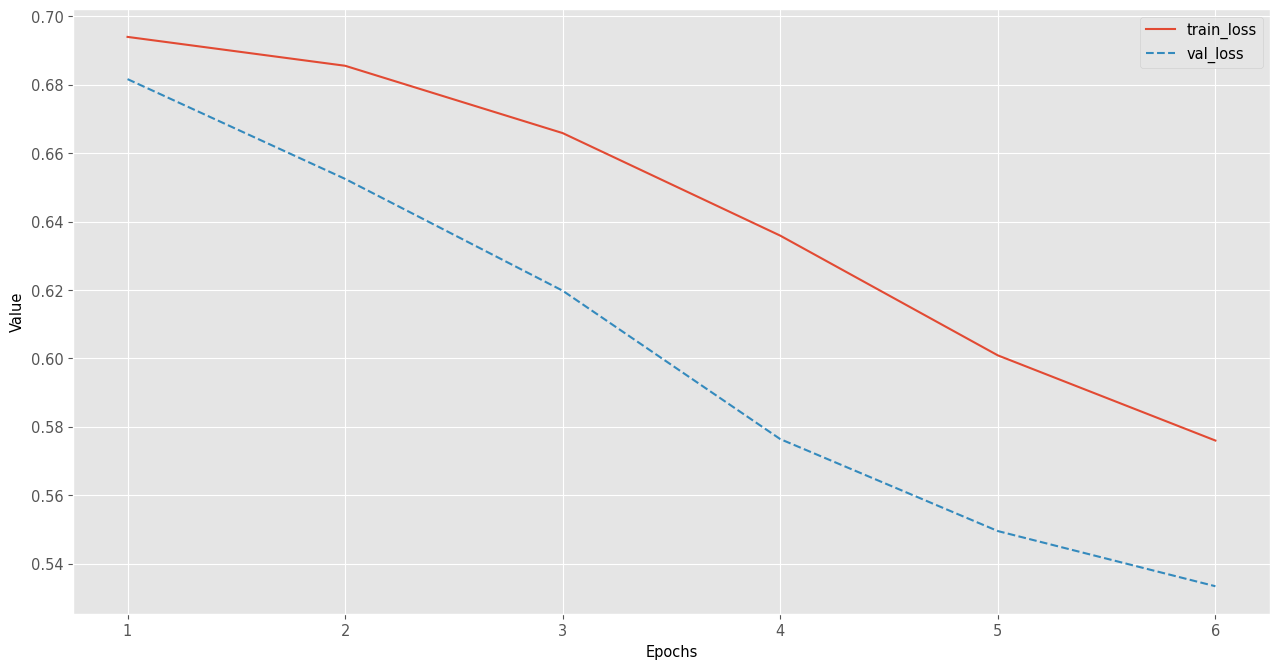

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


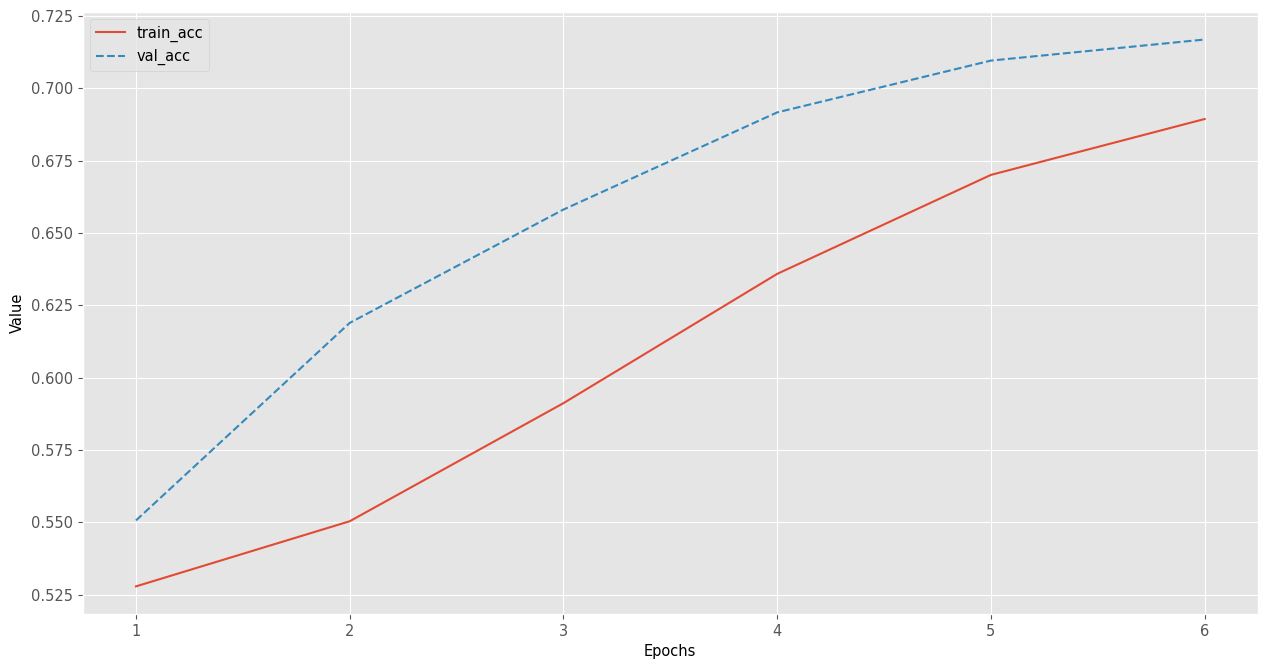

In [21]:
from sklearn.metrics import precision_recall_fscore_support

epochs = 6

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  print(precision_recall_fscore_support(train_labels, train_predict, average='macro'))


  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)
  print(precision_recall_fscore_support(valid_labels, valid_predict, average='macro'))

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

df = pd.DataFrame(list(zip()), columns=['Actual', 'Predicted'])

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/4 [00:00<?, ?it/s]

(0.5600694444444445, 0.5471132897603486, 0.5331174565793347, None)
  train_loss: 0.26449 - test_loss: 1.15350 - train_acc: 0.91284 - test_acc: 0.57377



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


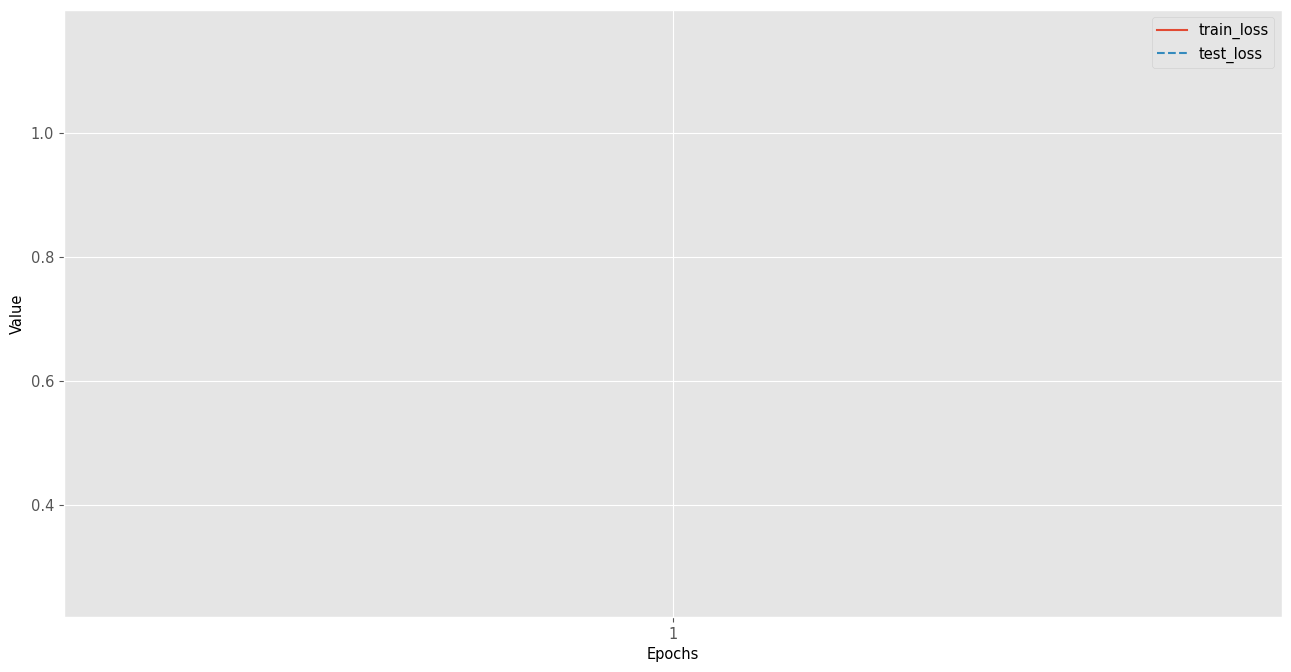

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


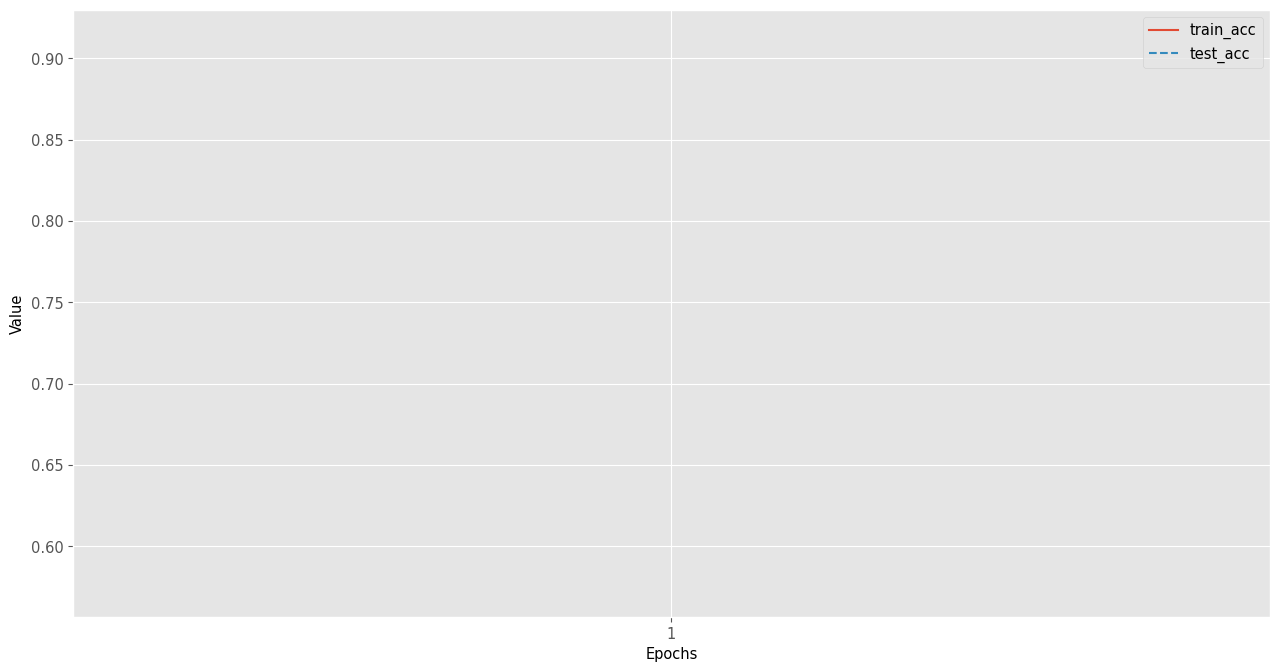

In [26]:
test_labels, test_predict, test_loss = validation(test_dataloader, device)
test_acc = accuracy_score(test_labels, test_predict)
print(precision_recall_fscore_support(test_labels, test_predict, average='macro'))

print("  train_loss: %.5f - test_loss: %.5f - train_acc: %.5f - test_acc: %.5f"%(train_loss, test_loss, train_acc, test_acc))
print()

all_loss = {'train_loss':[], 'test_loss':[]}
all_acc = {'train_acc':[], 'test_acc':[]}

all_loss['train_loss'].append(train_loss)
all_acc['train_acc'].append(train_acc)
all_loss['test_loss'].append(test_loss)
all_acc['test_acc'].append(test_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/126 [00:00<?, ?it/s]

(0.532903525324228, 0.5327272131447082, 0.532050147551285, None)
Validation on batches...


  0%|          | 0/14 [00:00<?, ?it/s]

(0.5063592525617843, 0.5063398902287568, 0.5054344288968435, None)
  train_loss: 0.70110 - val_loss: 0.71385 - train_acc: 0.53264 - valid_acc: 0.50559


Training on batches...


  0%|          | 0/126 [00:00<?, ?it/s]

(0.5669031985249242, 0.5668126605005332, 0.566638263634154, None)
Validation on batches...


  0%|          | 0/14 [00:00<?, ?it/s]

(0.5339857579658835, 0.5338427947598253, 0.5336463223787167, None)
  train_loss: 0.68036 - val_loss: 0.71514 - train_acc: 0.56677 - valid_acc: 0.53468


Training on batches...


  0%|          | 0/126 [00:00<?, ?it/s]

(0.6305117311772761, 0.629964965452043, 0.6296259015254844, None)
Validation on batches...


  0%|          | 0/14 [00:00<?, ?it/s]

(0.5269696277688971, 0.5236569047714434, 0.5106846586045354, None)
  train_loss: 0.64849 - val_loss: 0.75733 - train_acc: 0.63004 - valid_acc: 0.52796


Training on batches...


  0%|          | 0/126 [00:00<?, ?it/s]

(0.6587218581022667, 0.6583893243933006, 0.6582458676252749, None)
Validation on batches...


  0%|          | 0/14 [00:00<?, ?it/s]

(0.4944670280036134, 0.4955831096510557, 0.4713930414216245, None)
  train_loss: 0.61639 - val_loss: 0.75303 - train_acc: 0.65845 - valid_acc: 0.50112


Training on batches...


  0%|          | 0/126 [00:00<?, ?it/s]

(0.701497135701412, 0.7012532695932299, 0.7011911473894723, None)
Validation on batches...


  0%|          | 0/14 [00:00<?, ?it/s]

(0.5080809901465994, 0.5080826088698369, 0.5078275144138373, None)
  train_loss: 0.58039 - val_loss: 0.76876 - train_acc: 0.70130 - valid_acc: 0.50783


Training on batches...


  0%|          | 0/126 [00:00<?, ?it/s]

(0.7194990913334062, 0.7194912443421391, 0.7194806993885106, None)
Validation on batches...


  0%|          | 0/14 [00:00<?, ?it/s]

(0.4975607287449393, 0.4975862345258603, 0.49676329862088375, None)
  train_loss: 0.55668 - val_loss: 0.78058 - train_acc: 0.71948 - valid_acc: 0.49888



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


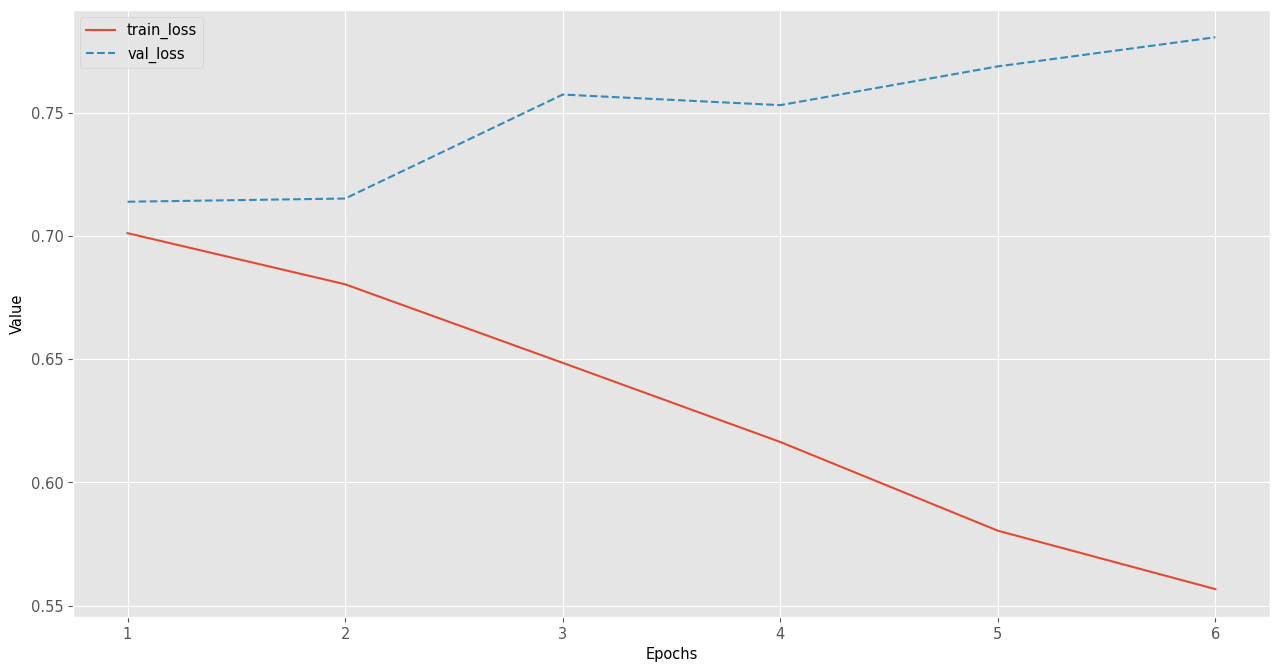

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


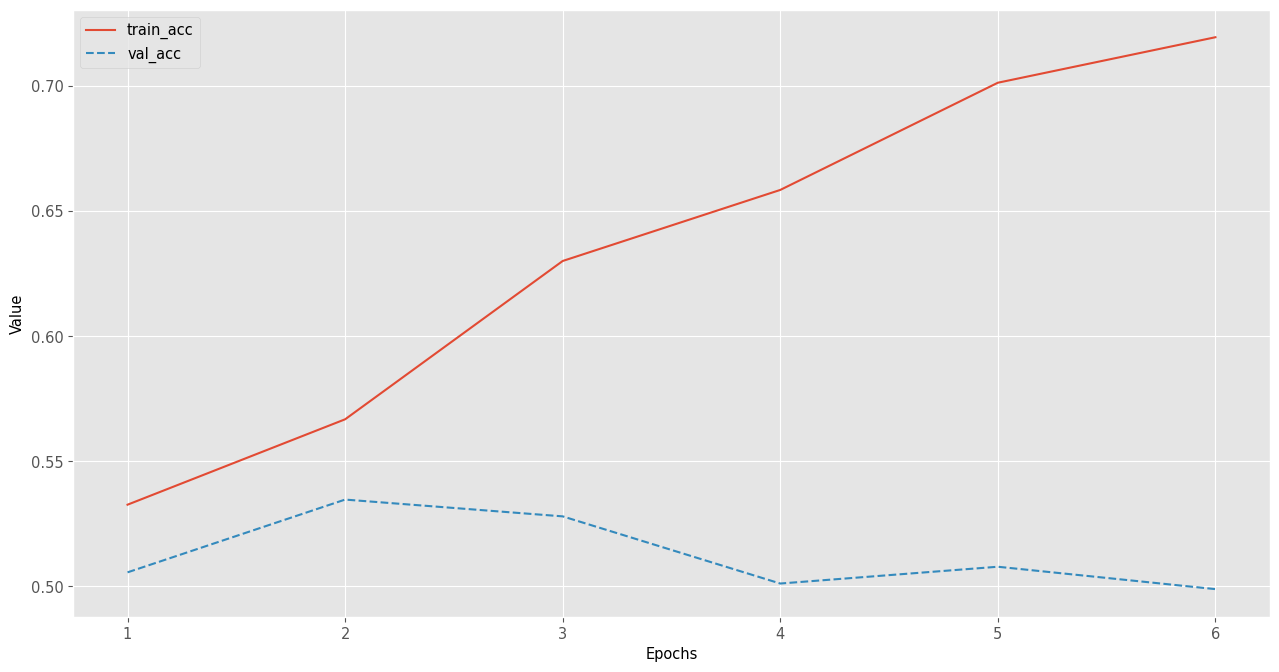

In [14]:
from sklearn.metrics import precision_recall_fscore_support

epochs = 6

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  print(precision_recall_fscore_support(train_labels, train_predict, average='macro'))


  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)
  print(precision_recall_fscore_support(valid_labels, valid_predict, average='macro'))

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

df = pd.DataFrame(list(zip()), columns=['Actual', 'Predicted'])

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.5049669178900147, 0.5048279775585008, 0.5020593628045903, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.5475099884652034, 0.5285974471596254, 0.46486889778063945, None)
  train_loss: 0.73216 - val_loss: 0.69368 - train_acc: 0.50643 - valid_acc: 0.50811


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.5192856509720041, 0.5188723071333992, 0.5169167296500479, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.5543749820107648, 0.5237618170749501, 0.4575751109721976, None)
  train_loss: 0.69398 - val_loss: 0.68070 - train_acc: 0.52027 - valid_acc: 0.54785


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.5473160117138005, 0.5464408469704873, 0.5449504015681877, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.6030381073427431, 0.5581225252692961, 0.5152443863431077, None)
  train_loss: 0.68579 - val_loss: 0.67442 - train_acc: 0.54773 - valid_acc: 0.57918


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.5810042168562413, 0.5807506783332279, 0.5806439796433344, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.6567988865692415, 0.5991929925185777, 0.5696816008089916, None)
  train_loss: 0.67011 - val_loss: 0.64539 - train_acc: 0.58128 - valid_acc: 0.61835


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.6238046189920741, 0.6235590814024445, 0.6235469251871604, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.6740415536685487, 0.6477184680945265, 0.6409569054171591, None)
  train_loss: 0.64195 - val_loss: 0.60718 - train_acc: 0.62398 - valid_acc: 0.65976


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.6629160833573576, 0.6625887230119124, 0.6626063569890523, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.6940095485039306, 0.6778730774455497, 0.6761767682912623, None)
  train_loss: 0.60705 - val_loss: 0.57074 - train_acc: 0.66299 - valid_acc: 0.68663


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.6874618454784938, 0.6869427492392715, 0.6869675228935674, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.7120306622096827, 0.7087119325414195, 0.7093187083053787, None)
  train_loss: 0.57721 - val_loss: 0.54731 - train_acc: 0.68741 - valid_acc: 0.71237


Training on batches...


  0%|          | 0/698 [00:00<?, ?it/s]

(0.7054796833968207, 0.7052720718047547, 0.7053185917744031, None)
Validation on batches...


  0%|          | 0/56 [00:00<?, ?it/s]

(0.7154431203426148, 0.6990620550515951, 0.6982499744129425, None)
  train_loss: 0.55837 - val_loss: 0.54265 - train_acc: 0.70555 - valid_acc: 0.70733



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


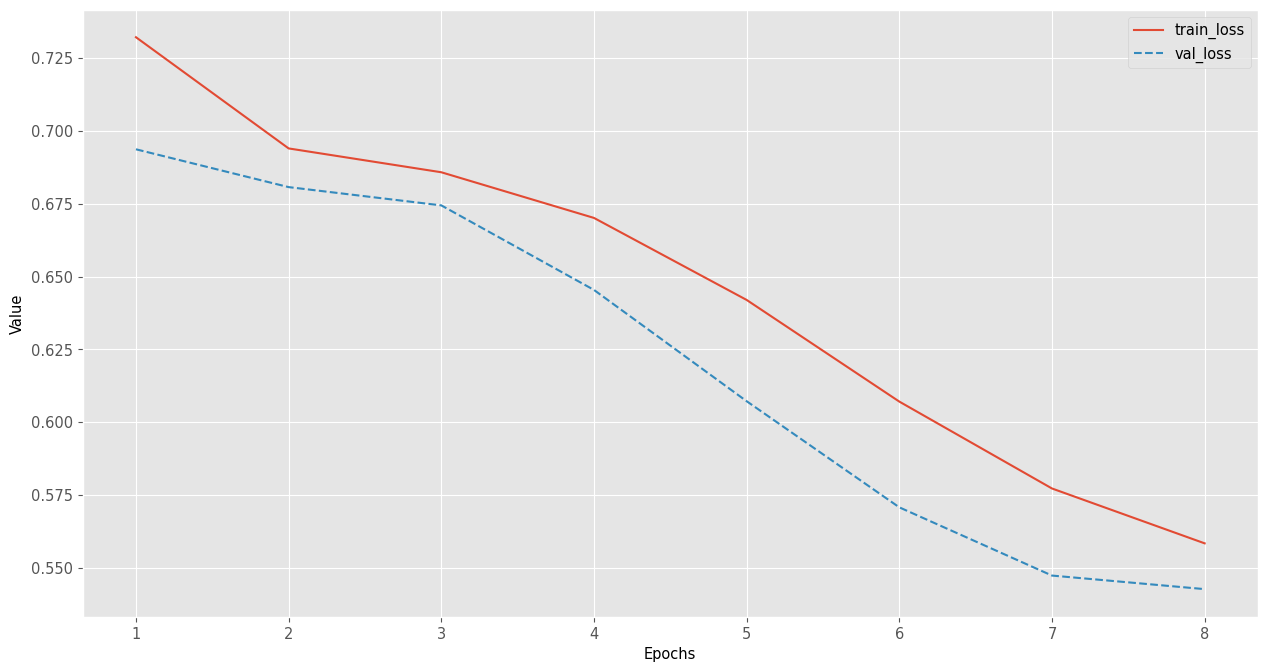

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


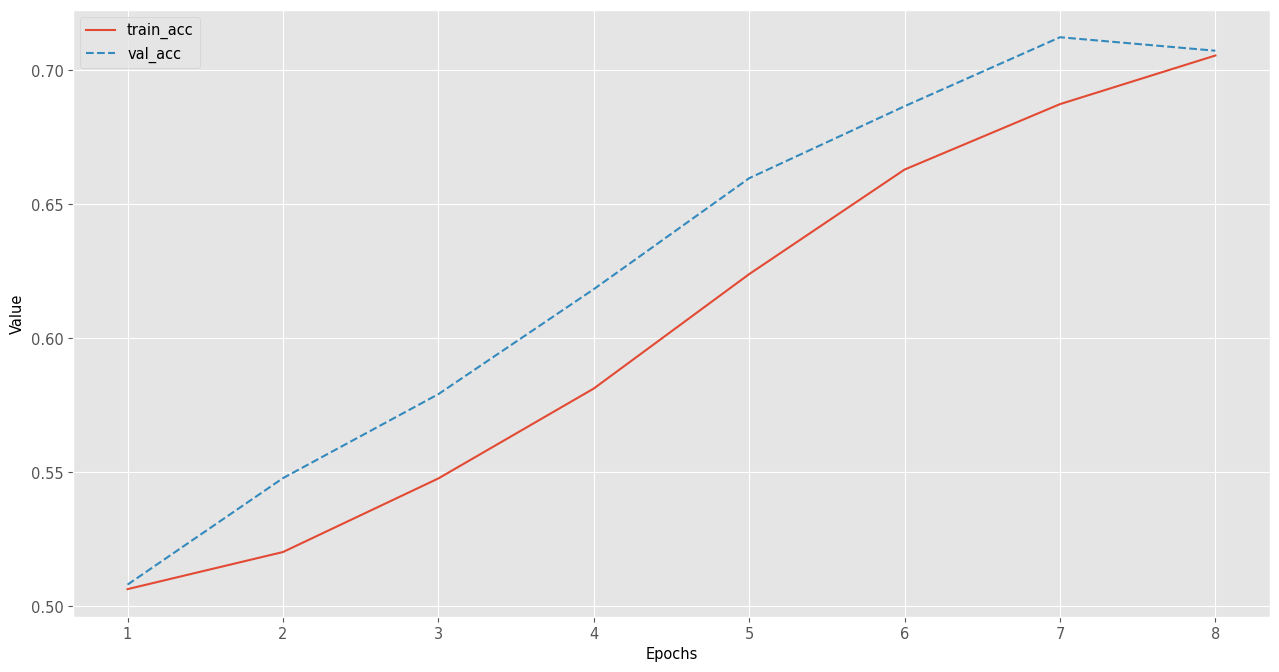

In [25]:
from sklearn.metrics import precision_recall_fscore_support

epochs = 8

# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  print(precision_recall_fscore_support(train_labels, train_predict, average='macro'))


  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)
  print(precision_recall_fscore_support(valid_labels, valid_predict, average='macro'))

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

df = pd.DataFrame(list(zip()), columns=['Actual', 'Predicted'])

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])